In [125]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import function, data, concat, Tensor, random, GradientTape, zeros, ones
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Conv2D, LeakyReLU, Input, Reshape, Conv2DTranspose, GlobalMaxPooling2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

In [126]:
class Generator:
    def __init__(self, input_dims: int = 200):
        self._input_dims = input_dims
        self._fc1 = Dense(7 * 7 * 128)
        self._lre1 = LeakyReLU(alpha=0.2)
        self._resize = Reshape((7, 7, 128))
        self._ct1 = Conv2DTranspose(filters=128, kernel_size=(4, 4), strides=2, padding="same")
        self._lre2 = LeakyReLU(alpha=0.2)
        self._ct2 = Conv2DTranspose(filters=128, kernel_size=(4, 4), strides=2, padding="same")
        self._lre3 = LeakyReLU(alpha=0.2)
        self._c1 = Conv2D(filters=1, kernel_size=(7, 7), strides=1, padding="same", activation="sigmoid")

    def __call__(self, training: bool = None) -> Model:
        x = Input(shape=(self._input_dims, ))
        y = self._fc1(x)
        y = self._lre1(y)
        y = self._resize(y)
        y = self._ct1(y)
        y = self._lre2(y)
        y = self._ct2(y)
        y = self._lre3(y)
        y = self._c1(y)
        return Model(inputs=x, outputs=y)

class Discriminator:
    def __init__(self, input_shape: tuple = (28, 28, 1)):
        self._input_shape = input_shape
        self._c1 = Conv2D(filters=64, kernel_size=(3, 3), strides=2, padding="same")
        self._lre1 = LeakyReLU(alpha=0.2)
        self._c2 = Conv2D(filters=128, kernel_size=(3, 3), strides=2, padding="same")
        self._lre2 = LeakyReLU(alpha=0.2)
        self._gmpool = GlobalMaxPooling2D()
        self._fc1 = Dense(1)

    def __call__(self, training: bool = None) -> Model:
        x = Input(shape=self._input_shape)
        y = self._c1(x)
        y = self._lre1(y)
        y = self._c2(y)
        y = self._lre2(y)
        y = self._gmpool(y)
        y = self._fc1(y)
        return Model(inputs=x, outputs=y)

In [127]:
gen = Generator(128)()
gen.summary()
dis = Discriminator()()
dis.summary()

gen_opt = Adam(learning_rate=0.0004)
dis_opt = Adam(learning_rate=0.0003)

loss_fn = BinaryCrossentropy(from_logits=True)

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_34 (Dense)             (None, 6272)              809088    
_________________________________________________________________
leaky_re_lu_65 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_13 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_26 (Conv2DT (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_66 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_27 (Conv2DT (None, 28, 28, 128)       262

In [128]:
def load_data(batch_size: int) -> (data.Dataset, int):
    (x_train, _), (x_test, _) = mnist.load_data()
    all_data = np.concatenate([x_train, x_test], axis=0)
    all_data = all_data.astype("float32") / 255.
    all_data = np.reshape(all_data, (-1, 28, 28, 1))
    real_x = data.Dataset.from_tensor_slices(all_data)
    return real_x.shuffle(buffer_size=10000).batch(batch_size), all_data.shape[0]

In [129]:
@function
def train_step(batch_img: Tensor):
    batch_size = batch_img.shape[0]
    gen_input = random.normal(shape=(batch_size, 128))
    fake_img = gen(gen_input)
    real_fake_img_set = concat([batch_img, fake_img], axis=0)
    real_fake_label_set = concat([ones(shape=(batch_size, 1)), zeros(shape=(batch_size, 1))], axis=0)
    # 添加随机噪点（gan技巧）
    real_fake_label_set += 0.05 * random.uniform(real_fake_label_set.shape)

    # 训练判决器（参考tf官方https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch）
    with GradientTape() as dis_G:
        d_preds = dis(real_fake_img_set)
        d_loss = loss_fn(real_fake_label_set, d_preds)
    d_gradiant = dis_G.gradient(d_loss, dis.trainable_weights)
    dis_opt.apply_gradients(zip(d_gradiant, dis.trainable_weights))

    # 训练生成器
    gen_input = random.normal(shape=(batch_size, 128))
    to_real_label = ones(shape=(batch_size, 1))

    with GradientTape() as gen_G:
        d_preds = dis(gen(gen_input))
        g_loss = loss_fn(to_real_label, d_preds)
    g_gradiant = gen_G.gradient(g_loss, gen.trainable_weights)
    gen_opt.apply_gradients(zip(g_gradiant, gen.trainable_weights))

    return d_loss, g_loss # , fake_img

In [130]:
def show_img(fake_img: Tensor):
    _ = plt.figure()
    axis_x = int(np.sqrt(fake_img.shape[0]))
    for num, img in enumerate(fake_img, start=1):
        plt.subplot(axis_x, axis_x, num)
        plt.axis("off")
        plt.imshow(img)
    plt.show()

In [131]:
def train():
    epochs = 10
    batch_size = 64
    dataset, dataset_length = load_data(batch_size)
    for epoch in range(1, epochs + 1):
        for num, batch_img in enumerate(dataset, start=1):
            d_loss, g_loss = train_step(batch_img)
            print(f'\r{epoch=},进度:{num}/{dataset_length // batch_size},生成器损失:{g_loss.numpy()},判决器损失:{d_loss.numpy()}', end='', flush=True)
        gen_input = random.normal(shape=(batch_size, 128))
        show_img(gen(gen_input))
        print()


epoch=1,进度:1094/1093,生成器损失:1.7678289413452148,判决器损失:0.35409542918205265

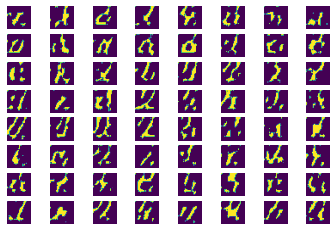


epoch=2,进度:1094/1093,生成器损失:2.653061866760254,判决器损失:0.110223509371280677

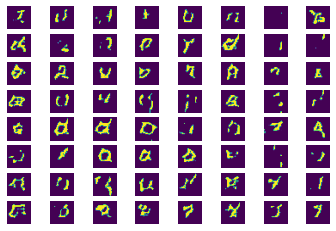


epoch=3,进度:1094/1093,生成器损失:0.9555990695953369,判决器损失:0.6463764905929565

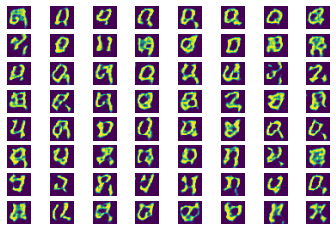


epoch=4,进度:1094/1093,生成器损失:0.8561738133430481,判决器损失:0.55574804544448853

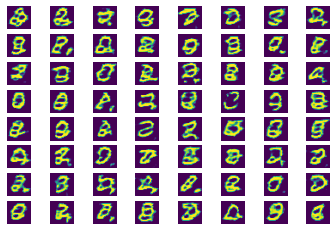


epoch=5,进度:1094/1093,生成器损失:0.8748893737792969,判决器损失:0.6086824536323547

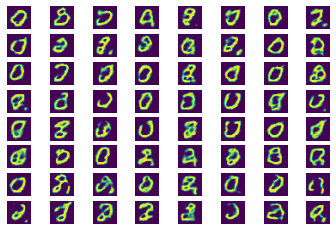


epoch=6,进度:1094/1093,生成器损失:0.7579193115234375,判决器损失:0.6204656958580017

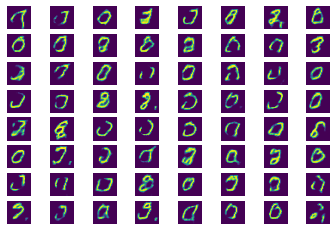


epoch=7,进度:1094/1093,生成器损失:0.8772411346435547,判决器损失:0.58909076452255255

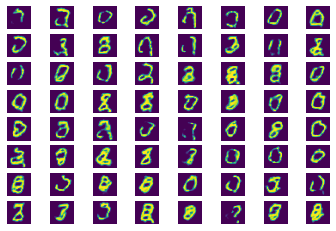


epoch=8,进度:1094/1093,生成器损失:1.0860666036605835,判决器损失:0.5308835506439209

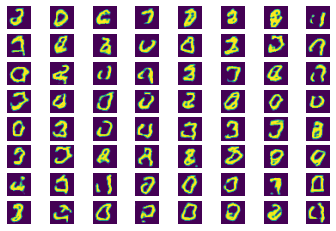


epoch=9,进度:1094/1093,生成器损失:0.761885404586792,判决器损失:0.60924428701400766

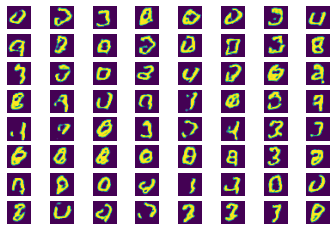


epoch=10,进度:1094/1093,生成器损失:0.958635151386261,判决器损失:0.59986674785614012

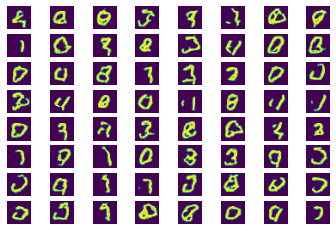

In [132]:
train()